# 5TF078 Deep Learning Course
## Excercise 1 Convolutional Neural Networks on Fashion-MNIST
Created by Tomas Nordström, Umeå University

Revisions:
* 2022-03-23 First revision based on earlier excercises /ToNo
* 2022-03-30 Adjusted the Keras Tuner search to reduce compute times. /Tomas
* 2022-04-05 Added padding='same' as an argument to Conv2D. /Tomas
* 2022-05-09 Swaped optimizer to use 'adam' as default and 'sgd' as extra test. /Tomas
* 2022-05-09 Fixed so that we can use the latest version (1.1.2) of keras tuner. /Tomas
* 2022-11-07 Added hints to use incremental model definitions when we want to have varying number of layers with Keras tuner. /Tomas
* 2022-11-09 Updated check for colab to NOT use env. var. COLAB_GPU as it has gone missing. /Tomas

## **Theodor Jonsson**

# First we initilize our Python environment

In [1]:
# Import needed libraries
import tensorflow as tf
print('TensorFlow version:', tf.__version__)

import tensorflow.keras as keras
# from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, BatchNormalization, Dropout, \
                         MaxPooling2D, Input, Activation, Add
# Optimizers
from keras.optimizers import Adam, RMSprop, Adagrad, SGD
# Identity block
from keras.utils  import to_categorical, plot_model
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.models import load_model
print('Keras version:',tf.keras.__version__)

# Helper libraries
import numpy as np
import sklearn
from   sklearn.model_selection import train_test_split

# Matlab plotting
import matplotlib
import matplotlib.pyplot as plt

# Typing imports for type hints / readability
from typing import Tuple, List, Dict, Any, Union
import os
# NOTE: Fix the seed for reproducability
np.random.seed(0)
tf.random.set_seed(0)

2023-04-11 22:33:44.631330: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-11 22:33:45.811680: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/theodor/anaconda3/envs/tf/lib/
2023-04-11 22:33:45.811746: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/theodor/anaconda3/envs/tf/lib/
2023-04-11 22:33:45.811751: W tensorflow/compiler/tf2t

TensorFlow version: 2.11.0
Keras version: 2.11.0


In [2]:
# Test for GPU or MPS availability
import sys
if not tf.config.list_physical_devices('GPU'):
     print("No GPU was detected. CNNs can be very slow without a GPU.")
     IN_COLAB = 'google.colab' in sys.modules
     if IN_COLAB:
         print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
else:
     !nvidia-smi -L # Running on M1 Macbook so no "nvidia-smi"


GPU 0: NVIDIA GeForce RTX 3060 Ti (UUID: GPU-d19262ea-7136-1ab7-a1e9-2e1f76960c50)


2023-04-11 22:33:47.376252: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-11 22:33:47.385481: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-11 22:33:47.385824: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


# Set up the needed data sets

## Get hold of a data-set
In this exercise we will use Fashion MNIST dataset, which an alternative to MNIST (it is a little harder, but the image size is the same). This is available directly as a [Keras dataset](https://keras.io/datasets/). This is a dataset of 60,000 28x28 grayscale images of 10 fashion categories, along with a test set of 10,000 images. 

Note that we split our data into **three** data sets: training, validation, testing; each with its own purpose.

In [3]:
# Get Fashion-MNIST training and test data from Keras database (https://keras.io/datasets/)
(train_images0, train_labels0), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

# Define labels
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Split the training set into a training and a validation set (20% is validation)
train_images, val_images, train_labels, val_labels = train_test_split(train_images0, train_labels0, test_size=0.20)
init = True

In [4]:
# Print som basic information of data set sizes and data sizes
train_no,x,y = train_images.shape
print('No training images:',train_no, ' with image size:',x,'x',y)
label_no = len(train_labels)
if (label_no != train_no) : 
  print('# labels do not match # training images')

test_no,x,y = test_images.shape
label_no = len(test_labels)
print('No test images:',test_no)
if (label_no != test_no) : 
  print('# labels do not match # test images')

val_no,x,y = val_images.shape
label_no = len(val_labels)
print('No val images:',val_no)
if (label_no != val_no) : 
  print('# labels do not match # val images')

classes = np.unique(train_labels)
num_classes = len(classes)
print('Training labels:', np.unique(train_labels), "; That is,", num_classes,"classes." )


No training images: 48000  with image size: 28 x 28
No test images: 10000
No val images: 12000
Training labels: [0 1 2 3 4 5 6 7 8 9] ; That is, 10 classes.


Note that the training labels are an integer between 0 and 9, which is not very good as outputs (or inputs) for DL models. A better approach would be to use a one-hot encoding. We can convert our label vectors to one-hot encoded matrices by using [to_categorical](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical) `tf.keras.utils.to_categorical(train_labels)`.

But we can achieve the same thing by using [SparseCategoricalCrossentropy](https://keras.io/api/losses/probabilistic_losses/#sparsecategoricalcrossentropy-class) as a loss function instead of the [CategoricalCrossentropy](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class). Also note that in both cases we need our model to have as many output nodes as we have classes! 

## Adjust the data to be better work as ML input

Many models working with images are assuming the data to be represented as a 4-D tensor with the shape BHWC [batch_size, height, width, channels] (some ML frameworks prefer to use BCHW instead, so be careful when starting to work on new datasets or ML-frameworks).

We also want to normalize data to be "small" and "close" to zero, e.g. 0 to 1 or –1 to 1. In this example we normalize to values between –0.5 and 0.5.

In [5]:
# Add an "empty" color dimension for our data sets
if init:
    train_images = np.expand_dims(train_images, -1)
    val_images = np.expand_dims(val_images, -1)
    test_images = np.expand_dims(test_images, -1)
    # Standardize the images.
    # train_images = (train_images - np.mean(train_images)) / np.std(train_images)
    # test_images = (test_images - np.mean(test_images)) / np.std(test_images)
    # val_images = (val_images - np.mean(val_images)) / np.std(val_images)
    # Normalize the images.
    train_images = (train_images / 255) - 0.5
    test_images = (test_images / 255) - 0.5
    val_images = (val_images / 255) - 0.5
    print('Training data shape:', train_images.shape)
    print('Max value:', np.max(train_images))
    print('Min value:', np.min(train_images))
    init = False

Training data shape: (48000, 28, 28, 1)
Max value: 0.5
Min value: -0.5


## Explore the data
It is always advised to take a look at the data, to see if we need to massage it further.

Images shape: (48000, 28, 28, 1), labels shape: (48000,)


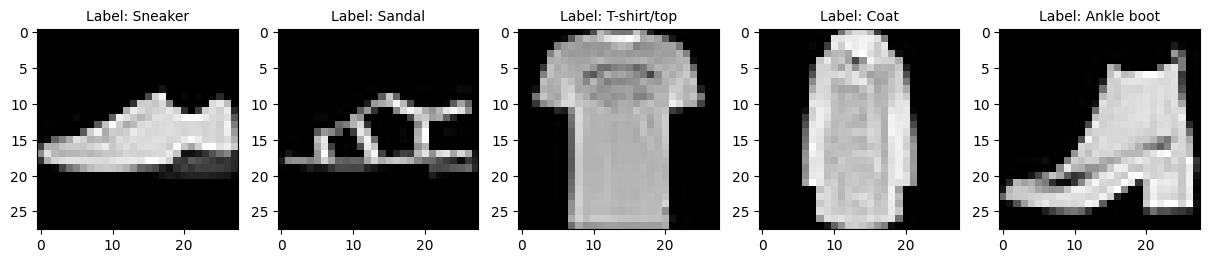

In [95]:
# As these are images (28x28) it can be interesting to plot some as images

image_index = [42, 789] # "Random" images to print
str2data = {
  "train": (train_images, train_labels),
  "val": (val_images, val_labels),
  "test": (test_images, test_labels)
}
def plot_sample(indexs:List[int]=None, data:str="train",n:int=2, model:Model=None,preds=None,pred_scores=None):
  images, labels = str2data[data]
  print(f"Images shape: {images.shape}, labels shape: {labels.shape}")
  fig,ax = plt.subplots(1,n,figsize=(n*3,3),dpi=100)
  if indexs is None:
    indexs = np.random.randint(0, images.shape[0], n)
  for i,index in zip(range(n),indexs):
    s = f"Label: {class_names[labels[index]]}"
    if model is not None or preds is not None:
      if model is not None:
        pred = model.predict(images[index].reshape(1, 28, 28, 1))
        cl, score = class_names[np.argmax(pred)], np.max(pred)
        s_model = (f"Prediction: {cl} ({score:.3f})")
      elif preds is not None:
        cl, score = class_names[preds[index]], pred_scores[index]
        s_model = (f"Prediction: {cl} ({score:.3f})")
      # The text should be below the image
      ax[i].text(0.5, -0.1, s_model, ha='center', transform=ax[i].transAxes,color='red' if cl != class_names[labels[index]] else 'green')
      ax[i].axis('off')
    ax[i].imshow(images[index], cmap='gray')
    ax[i].set_title(s)
    # Font size
    ax[i].title.set_fontsize(10)
    ax[i].grid(False)
plot_sample(data="train",n=5)

# Define a convolutional network model

## Define the model using Keras

Note that this is a *very* small modell just to have a strating point. A good modell is expected to have 5-50 times as many parameters!

In [7]:
# We need to give the input shape (i.e. our image shape) to our model
input_shape = test_images[0].shape
print("Input shape", input_shape)

# The Keras model will be the simplest Keras model for NN networks. 
# It is a single stack of layers connected sequentially.
def simple_model()->Sequential:
    model = Sequential([

    # Add a convolution layer
    Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape),

    # Flatten the input. This prepares the vector for fully connected layers.
    Flatten(),

    # Add a hidden Dense layer
    Dense(units=16, activation='relu'),

    # Add a an output layer. The output space is the number of classes
    #    Softmax makes the output as probablity vector of the different classes
    Dense(units=num_classes, activation='softmax')

    ])
    print("Simple Model")
    print(model.summary())
    return model
# model = simple_model()

Input shape (28, 28, 1)


# Set up the model and optimizer for training
To set up the optimization of this model we need to compile it, and set what [optimizer](https://keras.io/api/optimizers/), what [loss](https://keras.io/api/losses/), and what [metrics](https://keras.io/api/metrics/) to use. Where, metric is similar to a loss but not used during training but can be used to measure training progress.

The model (its parameters) is also initialized to some random values during this phase.

In [8]:
# model.compile(
#     optimizer='adam',
#     loss='categorical_crossentropy',
#     metrics=['categorical_accuracy']
# )

# Run the training

In [9]:
epochs = 15      ## Number of epoch to run
batch_size = 64  ## Mini batch size
def train_model(model:Model,
                epochs:int,
                batch_size:int,
                train:tuple,
                validation:tuple,
                callbacks=None)->keras.callbacks.History:
  train_images, train_labels = train
  val_images, val_labels = validation
  # Train the model.
  history = model.fit(
    train_images, to_categorical(train_labels),
    epochs=epochs,
    batch_size=batch_size,
    verbose = 1,
    validation_data=(val_images, to_categorical(val_labels)),
    callbacks=callbacks
  )
  return history

In [10]:
# Old model
# history = train_model(model, epochs, batch_size, (train_images, train_labels), (val_images, val_labels))

In [11]:
# plot_sample(data="val", model=model)

# Explore the training progress
Show the training progress, by plotting the training and validation accuracy and loss

In [12]:
def plot_history(history:keras.callbacks.History, epochs:int):
    epochs = min(epochs, len(history.history['loss']))
    epochrange = range(1, epochs + 1)
    train_acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']

    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.plot(epochrange, train_acc, 'bo-', label='Training acc')
    plt.plot(epochrange, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy (modell 1)')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.plot(epochrange, train_loss, 'bo-', label='Training loss')
    plt.plot(epochrange, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss (modell 1)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
# plot_history(history, epochs)

Loss: ![Training Loss](TrainingLossOrg.png)
Accuracy: ![Training Accuracy](TrainingAccOrg.png)

Notera hur träningsnoggrannheten konstant går uppåt (och träningsförlusten nedåt). Medan valideringsförlusten bottnar ut någonstans mellan 5-10 epochs för att sedan långsamt går uppåt. Detta tyder på en svag överträning, om förlusten hade fortsatt nedåt tillsammans med träningsförlusten hade modellen fortfarande varit undertränad. Men överlag kan vi misstänka att modellens kapacitet vid 15 epochs är det bästa som denna modell kan åstadkomma.

# Evaluate the model on the test data.
This first model get something around 89.5 % accuracy, not bad, but we can improve on this!

In [13]:
def eval(model:Model, data:str="test"):
    images, labels = str2data[data]
    # Evaluate the model.
    test_loss, test_acc = model.evaluate(images,to_categorical(labels))
    print(f'{data} accuracy: {test_acc:.4f}')
    return test_acc

## Theodor Jonsson Code
I'll write my code starting from here to keep the original code intact and to make use it as a reference.

## Model builder
Funktion som bygger modellen givet ett dictionary av parametrar som styr modellens arkitektur och andra hyperparametrar.

In [100]:
str2optim = {
    "adam": Adam,
    "rmsprop": RMSprop,
    "adagrad": Adagrad,
    "sgd":SGD,
}

def new_model(hp:dict)->Model:
    inp = Input(shape=input_shape)
    n_blocks = len(hp["depths"])
    x = inp
    for i in range(n_blocks):
        for j in range(hp["depths"][i]):
            if hp["skip"]:
                if j == 0:
                    pass
                    skip = Conv2D(filters=hp["filters"][i], kernel_size=(1, 1), padding='same',name=f"skip_{i}")(x)
                else:
                    pass
                    skip = x
            if i==0 and j==0:
                x = Conv2D(filters=hp["filters"][i], kernel_size=(hp["kernel_size"], hp["initial_kernel_size"]), padding='same',name=f"Initial_Conv")(x)
            x = Conv2D(filters=hp["filters"][i], kernel_size=(hp["kernel_size"], hp["kernel_size"]), padding='same',name=f"conv_{i}_{j}")(x)
            x = BatchNormalization(name=f"bn_{i}_{j}")(x) if hp["batch_norm"] else x
            x = Activation(hp["activation"],name=f"act_{str(hp['activation'])}_{i}_{j}")(x)
            x = Dropout(hp["dropout"],name=f"drop_{i}_{j}")(x)
            if hp["skip"]:
              x = Add()([x,skip])
        if isinstance(hp["pool"], bool) and hp["pool"]:
            x = MaxPooling2D(pool_size=(2, 2),name=f"pool_{i}")(x)
        else:
            x = Conv2D(filters=hp["filters"][i], kernel_size=(hp["pool"], hp["pool"]), padding='valid',name=f"downsample_{i}")(x)
            x = BatchNormalization(name=f"bn_{i}_down")(x) if hp["batch_norm"] else x
            x = Activation(hp["activation"],name=f"act_{str(hp['activation'])}_{i}_down")(x)
    # MLP
    x = Flatten()(x)
    mlp_depth = len(hp["dense_units"])
    for i in range(mlp_depth):
        x = Dense(hp["dense_units"][i])(x)
        x = BatchNormalization()(x) if hp["batch_norm"] else x
        x = Activation(hp["activation"])(x)
        x = Dropout(hp["dropout"])(x)
    x = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inp, outputs=x)
    optim = str2optim[hp["optimizer"]](learning_rate=hp["learning_rate"], decay=hp["weight_decay"], clipnorm=hp["clip_norm"])
    model.compile(
        optimizer=optim,
        loss='categorical_crossentropy',
        metrics=['categorical_accuracy'],
    )
    return model

In [15]:

hp = {
  "filters":[32, 64, 128],
  "initial_kernel_size":3,
  "kernel_size":3,
  "dropout":0.2,
  "batch_norm":True,
  "optimizer":"adam",
  "learning_rate":0.001,
  "weight_decay":0.0001,
  "clip_norm":2,
  "activation":"relu",
  "depths":[2, 2, 2],
  "pool":True,
  "skip":True,
  "dense_units": [128,32]
}

model = new_model(hp)
# Print number of parameters
print(f"Number of parameters: {model.count_params():,}")
epochs = 20
batch_size = 1024
model_dir = "models"
name = "model_1"
model_path = os.path.join(model_dir, name)
if not os.path.exists(model_path):
    os.makedirs(model_path)
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=6, verbose=1, mode='auto',restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.0001, verbose=1)
model_checkpoint = ModelCheckpoint(filepath=os.path.join(model_path, "model.h5"), monitor='val_loss', save_best_only=True, verbose=1)
callbacks = [reduce_lr, model_checkpoint]#,early_stopping]


Number of parameters: 460,650


2023-04-11 22:34:02.939361: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-11 22:34:02.939904: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-11 22:34:02.940265: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-11 22:34:02.940506: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

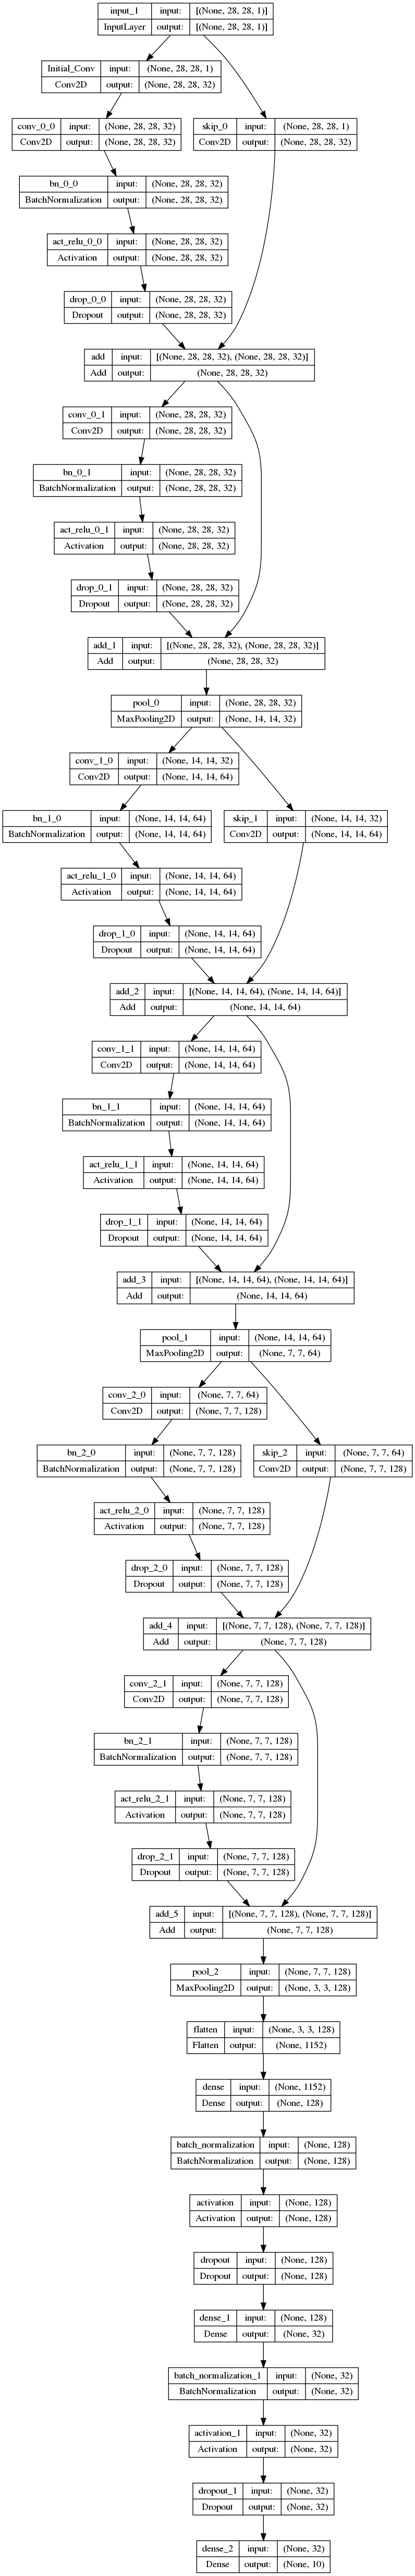

In [16]:
# Plot model
plot_model(model, to_file=os.path.join(model_path, "model.png"), show_shapes=True, show_layer_names=True)

Ovan kan man se en visualisering av beräkningsgrafen för modellen. Hjälper att visualisera hur modellen för att se att den är korrekt byggd.

In [17]:
history = train_model(model, epochs, batch_size, (train_images, train_labels), (val_images, val_labels),callbacks=callbacks)

Epoch 1/20


2023-04-11 15:35:30.306163: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/drop_0_0/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-04-11 15:35:31.197713: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-04-11 15:35:32.266066: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-11 15:35:33.073522: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


47/47 [==============================] - ETA: 0s - loss: 1.0426 - categorical_accuracy: 0.6996
Epoch 1: val_loss improved from inf to 2.03766, saving model to models/model_1/model.h5
47/47 [==============================] - 11s 123ms/step - loss: 1.0426 - categorical_accuracy: 0.6996 - val_loss: 2.0377 - val_categorical_accuracy: 0.3030 - lr: 0.0010
Epoch 2/20
47/47 [==============================] - ETA: 0s - loss: 0.5983 - categorical_accuracy: 0.8403
Epoch 2: val_loss did not improve from 2.03766
47/47 [==============================] - 5s 98ms/step - loss: 0.5983 - categorical_accuracy: 0.8403 - val_loss: 2.3990 - val_categorical_accuracy: 0.2035 - lr: 0.0010
Epoch 3/20
47/47 [==============================] - ETA: 0s - loss: 0.4566 - categorical_accuracy: 0.8703
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 3: val_loss did not improve from 2.03766
47/47 [==============================] - 5s 98ms/step - loss: 0.4566 - categorical_accuracy: 0.870

In [18]:
model = load_model(os.path.join(model_path, "model.h5"))
test_accuarcy = eval(model, "test")
n_parameters = model.count_params()
print(f"Number of parameters: {n_parameters:,}")

313/313 [==============================] - 1s 2ms/step - loss: 0.2998 - categorical_accuracy: 0.8973
test accuracy: 0.8973
Number of parameters: 460,650


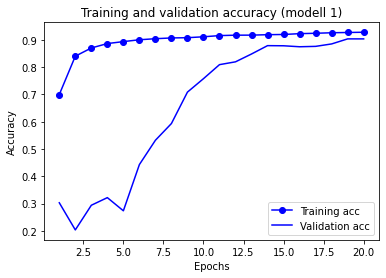

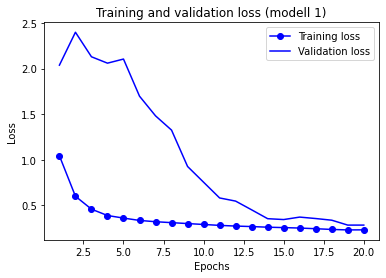

In [19]:
plot_history(history, epochs)

# Övning Del 1a
## Frågor att besvara:
* Hur många parametrar har din modell?
* Vilken testnoggrannhet får du? (Då modellen är slumpmässing initierad kan du få ett värde som skiljer sig lite grann.)
* Om du tittar på träningsförloppet, har modellen tränat färdigt eller är den undertränad eller kanske övertränad, vad i träningskurvorna kan avgöra det?
* Hur många epochs skulle ha varit lämpligt att använda?

## Svar till del 1a:
Min model 460,650 parametrar och uppnår en testnogrannhet på 89.73%. Modellen skulle möjlighen ha kunnat träna något längre för att minska skillnaden mellan träningsdatat och validationdatat. Vi kan anta att resultaten på validationsdatat hade ökat baserat på att det vid 10 iterationen trenderar uppåt. Därför hade det varit lämpligt att testa ett högre antal iteration, exempelvis 25 eller 30. Det är då viktigt att man övervakar skillnaden mellan träningsnoggrannheten och validationsnoggrannheten.

# Del 1b - Fortsatta experiment:
Det finns nu många saker du kan utforska men vi vill att du nu undersöker lite olika modeller. Undersök om du får en förbättring av testnoggrannhet ifall du gör modellen mer kraftfull (fler noder och/eller fler lager). Ha hela tiden ett öga på ifall modellen börjar överträna (att valideringsförlusten börjar gå uppåt igen). Notera att man gärna har med MaxPooling2D-lager mellan varje eller varannat faltningslager, då det hjälper med att hålla ner antalet parametrar vilket även leder till snabbare och ofta bättre träningsresultat (ger tex en viss extra translations och skalinvarians). Detta är speciellt viktigt om man har stora inbilder, men kan nog ge bra effekt även på våra minimala bilder.

Målet är att få modellen att bli komplex nog att väl kunna representera data. En viss överträning är OK, vi ska ju sedan åtgärda det med regularisering.
* Hur många faltningslager verkar rimligt att använda (håll dig under 4-5, det kan vara bättre att lägga till kärnor istället.
* Hur många kärnor/noder verkar vettigt att använda?
* Pröva även att använda ex 5x5 kärna för det första eller kanske något lager till, blir det bättre då? 
* Om en modell övertränar, gör ett experiment där du istället för att köra alla dina epochs slutar där verifieringsfelet börjar gå uppåt igen. Vad blir skillnaden i testnoggrannhet?

Du behöver inte ha med kod för alla experiment, om du inte vill, men vi vill åtminstone se koden, träningsförloppet, och testnoggrannheten för din bästa modell.

För minst en av dessa parameterinställningar ska du nå mer än 90% rätt på testdata för Fashion-MNIST.



In [ ]:
# Kod för din bästa modell och dess träning och utvärdering
### TESTING NO POOLING OR SKIP ###
# hp = {
#     "filters": 2*np.array([16,32,64,128]),
#     "initial_kernel_size": 5,
#     "kernel_size": 3,
#     "dropout": 0.01,
#     "batch_norm": True,
#     "optimizer": "adam",
#     "learning_rate": 0.005,
#     "weight_decay": 0.005,
#     "clip_norm": 2.0,
#     "activation": "selu",
#     "depths": [1,1,1,2],
#     "pool": 7,
#     "dense_units": [128,64],
#     "skip": False,
# }
### BEST MODEL ###
best_hp = {
    "filters": np.array([16,32,64,128]),
    "initial_kernel_size": 5,
    "kernel_size": 3,
    "dropout": 0.15,
    "batch_norm": True,
    "optimizer": "adam",
    "learning_rate": 0.01,
    "weight_decay": 0.0,
    "clip_norm": 2.0,
    "activation": "selu",
    "depths": [1,1,1,2],
    "pool": True,
    "dense_units": [128,64],
    "skip": True,
}
model = new_model(best_hp) # Compiled Model
# Print number of parameters
print(f"Number of parameters: {model.count_params():,}")
epochs = 20
batch_size = 2048
model_dir = "models"
name = "model_best"
model_path = os.path.join(model_dir, name)
if not os.path.exists(model_path):
    os.makedirs(model_path)
# Callbacks
# early_stopping = EarlyStopping(monitor='val_loss', patience=6, verbose=1, mode='auto',restore_best_weights=True) # Early stopping later.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.0001, verbose=1)
#model_checkpoint = ModelCheckpoint(filepath=os.path.join(model_path, "model.h5"), monitor='val_loss', save_best_only=True, verbose=1)
callbacks = [reduce_lr]#,early_stopping]
# plot_model(model, to_file=os.path.join(model_path, "model.png"), show_shapes=True, show_layer_names=True)

In [40]:
history = train_model(model, epochs, batch_size, (train_images, train_labels), (val_images, val_labels),callbacks=callbacks)

Epoch 1/20


2023-04-11 15:48:51.392534: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_9/drop_0_0/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


24/24 [==============================] - 3s 74ms/step - loss: 0.9377 - categorical_accuracy: 0.6671 - val_loss: 18.5070 - val_categorical_accuracy: 0.2314 - lr: 0.0100
Epoch 2/20
24/24 [==============================] - 2s 64ms/step - loss: 0.5310 - categorical_accuracy: 0.8036 - val_loss: 1.9503 - val_categorical_accuracy: 0.5710 - lr: 0.0100
Epoch 3/20
24/24 [==============================] - 2s 64ms/step - loss: 0.4336 - categorical_accuracy: 0.8424 - val_loss: 1.6888 - val_categorical_accuracy: 0.5670 - lr: 0.0100
Epoch 4/20
24/24 [==============================] - 2s 65ms/step - loss: 0.3753 - categorical_accuracy: 0.8637 - val_loss: 0.5485 - val_categorical_accuracy: 0.8093 - lr: 0.0100
Epoch 5/20
24/24 [==============================] - 2s 65ms/step - loss: 0.3436 - categorical_accuracy: 0.8763 - val_loss: 1.0565 - val_categorical_accuracy: 0.6876 - lr: 0.0100
Epoch 6/20
24/24 [==============================] - 2s 65ms/step - loss: 0.3158 - categorical_accuracy: 0.8853 - val_los

313/313 [==============================] - 1s 2ms/step - loss: 0.2568 - categorical_accuracy: 0.9113
test accuracy: 0.9113


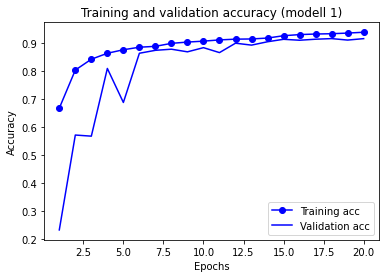

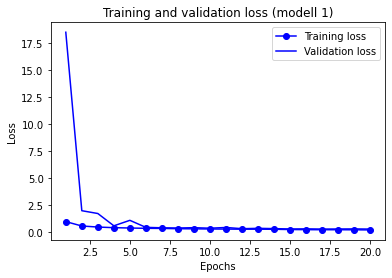

In [41]:
test_accuarcy = eval(model, "test")
plot_history(history, epochs)

## Analys
Dokumentera dina experiment, med modellkonfiguration, testnoggrannhet, och vid vilken epoch modellen börjar överträna.
* Gör en sammanfattande analys av dina experiment hittills.

## Svar till del 1b:

## Hyperparametrar
Dessa är de parametrar beskriver modellen, dessa skickas som ett dictionary till modellen vid kompileringen.

- filters (List[int]): Lista med antalet kärnor för varje lager.
- inital_kernel_size (int): Storleken på kärnan för det första lageret.
- kernel_size (int): Storleken på kärnan för de andra lageren.
- dropout (float): Dropout rate för varje lager.
- batch_norm (bool): Om batch normalization ska användas.
- optimizer (str): Namnet på optimizer.
- learning_rate (float): Lärarhastigheten för optimizer.
- weight_decay (float): För regularisering, minskar magnituden av vikterna.
- clipnorm (float): Gräns för normen av gradienten. Ökar stabiliteten i träningen.
- activation (str): Aktiveringsfunktionen för varje lager.
- depths (List[int]): Hur många lager per block som ska användas.
- pool (bool): Om MaxPooling ska användas eller om en "stridad" faltning ska användas.
- dense_units (List[int]). Antal noder att anväda i output lager.
- skip (bool): Om skip connections ska användas inom varje block.

## Modelkonfigurationer
Modellen är uppdelad i block som består av ett antal lager. Den vanligaste konfigurationen att använde var att jag använde block som bestod utav faltningslager, aktiveringslager, batch normalisering och max-pooling tillsammans med en skip connection från inputen av blocket till outputen. Detta tillåter gradienten att propagera genom hela nätet och tillåter större och mer komplexa modeller. Några av de konfigurationer jag testade var:

| Hyperparametrar | Valda värden |
| --- | --- |
| filters | [32, 64, 128] |
| inital_kernel_size | 3 |
| kernel_size | 3 |
| dropout | 0.2 |
| batch_norm | True |
| optimizer | Adam |
| learning_rate | 0.001 |
| weight_decay | 0.0001 |
| clip_norm | 2 |
| activation | ReLU |
| depths | [2, 2, 2] |
| pool | True |
| dense_units| [128,32] |
| skip | True |

Denna konfiguration gav en testnoggranhet på 90.16% efter 10 epochs. Min ursprungliga modell. 

Nästa modell använde en annan struktur med betydigt fler parametrar och mindra priors såsom maxpooling. Istället används faltningar med större kernels för dimensionsreduktion. Denna modell hade följande parametrar.

| Hyperparametrar | Valda värden |
| --- | --- |
| filters | [32, 64, 128, 256] |
| inital_kernel_size | 5 |
| kernel_size | 3 |
| dropout | 0.01 |
| batch_norm | True |
| optimizer | Adam |
| learning_rate | 0.005 |
| weight_decay | 0.005 |
| clip_norm | 2 |
| activation | SeLU |
| depths | [1, 1, 1, 2] |
| pool | False |
| dense_units| [128,32] |
| skip | False |

Denna modell använder varken pooling eller skip connections och når endat en testnoggrannhet på: 87.17%. Medan den tränas till 90.0% vilket indikerar att modellen övertränats.

Den bästa modellen blev en modell med både skip connections och pooling. Den har 4 filternivår och 1 block per nivå förutom sista då 2 blocks används för att öka komplexiteten av modellen. Modellen hade följande hyperparametrar:

<!--
"filters": np.array([16,32,64,128]),
"initial_kernel_size": 5,
"kernel_size": 3,
"dropout": 0.1,
"batch_norm": True,
"optimizer": "adam",
"learning_rate": 0.01,
"weight_decay": 0.01,
"clip_norm": 2.0,
"activation": "selu",
"depths": [1,1,1,2],
"pool": True,
"dense_units": [128,64],
"skip": True, 
-->
| Hyperparametrar | Valda värden |
| --- | --- |
| filters | [16, 32, 64, 128] |
| inital_kernel_size | 5 |
| kernel_size | 3 |
| dropout | 0.15 |
| batch_norm | True |
| optimizer | Adam |
| learning_rate | 0.01 |
| weight_decay | 0.0 |
| clip_norm | 2 |
| activation | SeLU |
| depths | [1, 1, 1, 2] |
| pool | True |
| dense_units| [128,64] |
| skip | True |

Denna modell hade en testnoggranhet på 91.13% medan validation och träningsnogggrannhet låg på ca 93%. Detta visar att det troligen går ändra parametrarna något för att uppnå ännu bättre resultat, förslagsvis öka på regularisering i modellen.

# Övning Del 2a - avbruten träning
Utgå ifrån din bästa modell som du fått fram i del 1 och för den implementera avbruten träning (eng. early stopping) som ett sätt att förhindra överträning. [See Geron s. 141]

Du behöver definiera en "callback" som sedan includeras i anropet till model.fit: *es=tf.keras.callbacks.EarlyStopping('val_loss', patience=3, restore_best_weights = True)*

*model.fit(
  train_images, to_categorical(train_labels),
  epochs=epochs,
  batch_size=batch_size,
  **callbacks=[es]**,
  validation_data=(val_images, to_categorical(val_labels))
)*

Viktigt är att notera restore_best_weights=True ifall man använder patience>0, för annars så har man en övertränad modell efter träningen.


In [ ]:
# Kod där du inför avbruten träning
model = new_model(best_hp) # Compiled Model
# Print number of parameters
print(f"Number of parameters: {model.count_params():,}")
epochs = 60
batch_size = 2048
model_dir = "models"
name = "model_best_es"
model_path = os.path.join(model_dir, name)
if not os.path.exists(model_path):
    os.makedirs(model_path)
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=6, verbose=1, mode='auto',restore_best_weights=True) # Early stopping later.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.0001, verbose=1)
# model_checkpoint = ModelCheckpoint(filepath=os.path.join(model_path, "model.h5"), monitor='val_loss', save_best_only=True, verbose=1)
callbacks = [reduce_lr,early_stopping]
# plot_model(model, to_file=os.path.join(model_path, "model.png"), show_shapes=True, show_layer_names=True)
history = train_model(model, epochs, batch_size, (train_images, train_labels), (val_images, val_labels),callbacks=callbacks)
test_accuarcy = eval(model, "test")
plot_history(history, epochs)


## Analys
Vid vilken Epoch stannar nu träningen? Ändras nu modellens testnoggrannhet då den inte övertränar?
## Svar:
Modellens testnoggrannhet ökade från 91.13% till 91.49% efter 29 iterationer. Man kan se från plotsen av noggrannheten och residualerna att modellen stagnerat därav avslutades träningsprocessen.
Man ser dessutom att träningsnoggrannheten ökar någorlunda och att variansen ökat. Modellen skulle därför kunna gynnas av att öka regulariserande termer så som drop-rate, weight decay, etc.

# Övning Del 2b Andra former av regularisering


Utgå ifrån din bästa modell som du fått fram i del 1 men använd avbruten träning. Nu ska du skapa en modell som använder regularisering, tex. drop-out eller batchnormalisering. Analysera och jämför dessa modeller (med och utan regularisering) genom att notera deras testnoggrannhet och plotta tränings- och valideringsnoggrannheten (eng. accuracy) respektive förlust (eng. loss), och notera ifall en förbättring kan iakttas med regularisering. Hur många Epoch använder du för träningen? [See Geron s 338, s. 365]

Number of parameters: 285,818
Epoch 1/60
 1/47 [..............................] - ETA: 1:07 - loss: 3.3620 - categorical_accuracy: 0.0820

2023-04-11 15:55:48.818110: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_12/drop_0_0/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


47/47 [==============================] - 3s 40ms/step - loss: 0.8710 - categorical_accuracy: 0.6879 - val_loss: 2.7457 - val_categorical_accuracy: 0.5679 - lr: 0.0100
Epoch 2/60
47/47 [==============================] - 2s 35ms/step - loss: 0.5001 - categorical_accuracy: 0.8185 - val_loss: 1.6538 - val_categorical_accuracy: 0.5828 - lr: 0.0100
Epoch 3/60
47/47 [==============================] - 2s 35ms/step - loss: 0.4135 - categorical_accuracy: 0.8514 - val_loss: 0.9092 - val_categorical_accuracy: 0.7190 - lr: 0.0100
Epoch 4/60
47/47 [==============================] - 2s 35ms/step - loss: 0.3730 - categorical_accuracy: 0.8653 - val_loss: 0.4605 - val_categorical_accuracy: 0.8403 - lr: 0.0100
Epoch 5/60
47/47 [==============================] - 2s 35ms/step - loss: 0.3442 - categorical_accuracy: 0.8784 - val_loss: 0.4824 - val_categorical_accuracy: 0.8262 - lr: 0.0100
Epoch 6/60
47/47 [==============================] - 2s 35ms/step - loss: 0.3220 - categorical_accuracy: 0.8846 - val_loss

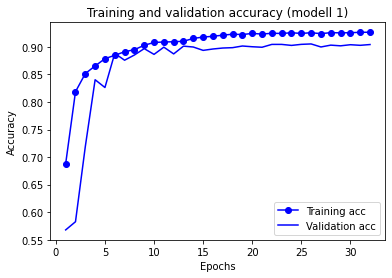

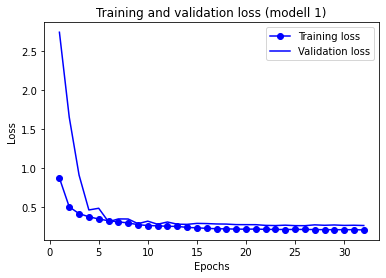

In [44]:
# Kod där du inför regularisering.

# NOTE: Jag hade redan implementerat drop-out och batchnormalisering men jag provar skruva upp parametrarna för se om det reducerar variansen eller om det endast ökar biasen.
# Kod där du inför avbruten träning
hp = {
    "filters": np.array([16,32,64,128]),
    "initial_kernel_size": 5,
    "kernel_size": 3,
    "dropout": 0.3,
    "batch_norm": True,
    "optimizer": "adam",
    "learning_rate": 0.01,
    "weight_decay": 0.001,
    "clip_norm": 1.0,
    "activation": "selu",
    "depths": [1,1,1,2],
    "pool": True,
    "dense_units": [128,64],
    "skip": True,
}
model = new_model(hp) # Compiled Model
# Print number of parameters
print(f"Number of parameters: {model.count_params():,}")
epochs = 60
batch_size = 2048
model_dir = "models"
name = "model_best_es"
model_path = os.path.join(model_dir, name)
if not os.path.exists(model_path):
    os.makedirs(model_path)
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=6, verbose=1, mode='auto',restore_best_weights=True) # Early stopping later.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.0001, verbose=1)
# model_checkpoint = ModelCheckpoint(filepath=os.path.join(model_path, "model.h5"), monitor='val_loss', save_best_only=True, verbose=1)
callbacks = [reduce_lr,early_stopping]
# plot_model(model, to_file=os.path.join(model_path, "model.png"), show_shapes=True, show_layer_names=True)
history = train_model(model, epochs, batch_size, (train_images, train_labels), (val_images, val_labels),callbacks=callbacks)
test_accuarcy = eval(model, "test")
plot_history(history, epochs)


## Analys
Analysera och jämför dina modeller (med och utan regularisering) genom att notera deras testnoggrannhet och plotta tränings- och valideringsnoggrannheten (eng. accuracy) respektive förlust (eng. loss), och notera ifall en förbättring kan iakttas med regularisering. Hur många Epoch använder du för träningen? 

## Svar:
Eftersom jag redan implementerat batchnormalisering, drop-out, weight-decay och gradient clipping i övning 1-2a ökade jag på dessa effekter. Detta resulterade dock i att skillnaden mellen tränings-, validation- och testnoggrannheten minskade drastiskt. Dock Minskade testnoggrannheten från 91.49% efter 29 iterationer till 90.27% efter 32 iterationer.

# Övriga Hyperparametrar
Det finns ett antal andra viktiga parametrar som man kan behöva justera. Men flera av dem hänger ihop, så man behöver jobba med olika modeller och data för att få en bra känsla för dem. [See Geron s. 325.., s. 351.. ]
* Batch size / batch storlek -- Ett större värde här kan ge GPUn mer parallellism att arbeta med, dvs snabbare, men ett för stort värde kan ge minnesproblem i GPUn och dessutom göra inlärningen långsammare (man kan dock även ha större LR i så fall.
* Optimizer / optimerare -- En vanlig och bra optimerade är Adam (den är dessutom ganska okänslig för vilken inlärningstakt som den startar med, vilket gör att skönsvärdet fugerar bra). Medan sgd är en mer "ursprunglig" optimerare.
* Learning rate / inlärningstakt (LR) -- Viktig parameter för hur snabbt modellen tränar, men för stort färde kan ge instabil träning.

# Övning Del 2c
Byt ut optimeraren från adam till sgd (med regularisering och avbruten träning). Jämför träningsförfarandet mellan de två optimerarna (skillnad i testnoggrannhet, vilken epoch stannade träningen, etc.?). 

Number of parameters: 285,818
Epoch 1/60
 1/47 [..............................] - ETA: 1:02 - loss: 3.3947 - categorical_accuracy: 0.0791

2023-04-11 17:55:00.109229: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_13/drop_0_0/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


47/47 [==============================] - 3s 40ms/step - loss: 1.3012 - categorical_accuracy: 0.5588 - val_loss: 1.5651 - val_categorical_accuracy: 0.4966 - lr: 0.0100
Epoch 2/60
47/47 [==============================] - 2s 35ms/step - loss: 0.8364 - categorical_accuracy: 0.7089 - val_loss: 1.8919 - val_categorical_accuracy: 0.3043 - lr: 0.0100
Epoch 3/60
47/47 [==============================] - ETA: 0s - loss: 0.7392 - categorical_accuracy: 0.7392
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
47/47 [==============================] - 2s 35ms/step - loss: 0.7392 - categorical_accuracy: 0.7392 - val_loss: 1.8895 - val_categorical_accuracy: 0.3535 - lr: 0.0100
Epoch 4/60
47/47 [==============================] - 2s 35ms/step - loss: 0.6984 - categorical_accuracy: 0.7520 - val_loss: 1.7823 - val_categorical_accuracy: 0.4218 - lr: 0.0050
Epoch 5/60
47/47 [==============================] - 2s 35ms/step - loss: 0.6749 - categorical_accuracy: 0.7611 - val_loss: 1.5566

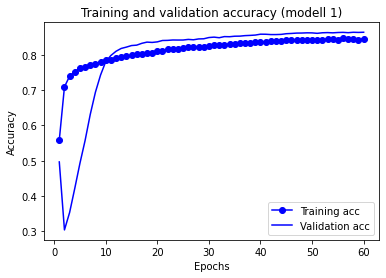

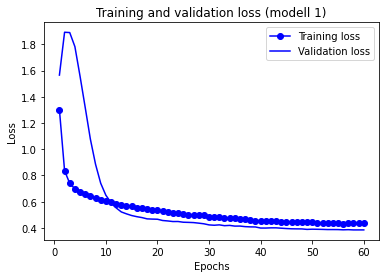

In [52]:
# Din kod för en körning med sgd som optimerare
import copy
sgd_hp = copy.copy(best_hp) # Kopiera de bästa hyperparametrarna från tidigare.
sgd_hp["optimizer"] = "sgd" # Erstatta optimeraren med Stochastic Gradient Descent.
model = new_model(sgd_hp) # Compiled Model
print(f"Number of parameters: {model.count_params():,}")
epochs = 60
batch_size = 2048
model_dir = "models"
name = "model_sgd_es"
model_path = os.path.join(model_dir, name)
if not os.path.exists(model_path):
    os.makedirs(model_path)
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=6, verbose=1, mode='auto',restore_best_weights=True) # Early stopping later.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.0001, verbose=1)
# model_checkpoint = ModelCheckpoint(filepath=os.path.join(model_path, "model.h5"), monitor='val_loss', save_best_only=True, verbose=1)
callbacks = [reduce_lr,early_stopping]
# plot_model(model, to_file=os.path.join(model_path, "model.png"), show_shapes=True, show_layer_names=True)
history = train_model(model, epochs, batch_size, (train_images, train_labels), (val_images, val_labels),callbacks=callbacks)
test_accuarcy = eval(model, "test")
plot_history(history, epochs)

## Svar till 2c:

Vi ser att testresultaten är betydligt sämre då vi använder Stochastic Gradient Descent än då vi använder Adam algoritmen. 

|Optimerings Algoritm| Testnogggrannhet | Epoch|
|---|---|---|
|SGD| 85.41% | 60 |
|Adam| 91.49% | 29 |

Om vi analyserar historiken över modellens error så ser vi att den användningen av `SGD` resulterar i enbetydligt mjukare kurva och den skulle 


# Del 3 Auto tune
Here we test on of the hyperparameter optimizers called Keras Tuner. Documentation can be found here: https://keras-team.github.io/keras-tuner/

In [104]:
# Get Keras Tuner (if in colab)
import sys
if 'google.colab' in sys.modules:
  !pip install keras_tuner -q

import keras_tuner
print('Keras Tuner version:', keras_tuner.__version__)

# Get some tuner search functions
from keras_tuner.tuners import BayesianOptimization
import kerastuner as kt

Keras Tuner version: 1.3.0


/tmp/ipykernel_26966/146912041.py:11: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


## Exempelmodell (du ska sedan göra en egen!)

In [105]:
# This is a straight forward CNN model to decently solve Fashion MNIST
# Note that we have no regularisation for this example!
# It can at least achieve 92% accuracy for me, with the parameters found:
# conv_1_filter =  96, conv_1_kernel =   5, 
# conv_2_filter =  48, conv_2_kernel =   5
# dense_1_units =  128
# learning_rate = 0.001
# batch_size = 320

def build_model_2Conv1Dense(hp):  
  model = tf.keras.Sequential([
    # First Convolutional Layer
    tf.keras.layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=256, step=32),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        activation='relu',
        padding='same',
        input_shape=(28,28,1)
    ),
    tf.keras.layers.BatchNormalization(),

    # Second Convolutional Layer
    tf.keras.layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=256, step=32),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        activation='relu',
        padding='same'
    ),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)),

    # A First Dense Layer
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=256, step=32),
        activation='relu'
    ),

    # A Final Dense Layer
    tf.keras.layers.Dense(10, activation='softmax')
  ])
  
  model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

# Övning 3: Kod för instrumentera din egen model att optimeras med Keras Tuner
Utgå ifrån din bästa modell som du fått fram i del 2 och instrumentera den för att optimeras med Keras Tuner.

In [106]:

depth_combs = [[1,1,1,1],[1,2,3,4],[1,4,6,8]] # Possible combinations of depth of the convolutional layers
dense_combs = [[128,64],[64,32]] # Possible combinations of number of units in the dense layers (MLP after feature extraction)
def build_model_MyModel(hp):  
  
  # My build functions is already compatible with with to use a tuner via a dictionary.
  # Declare all the hyperparameters we want to tune
  hp_f1 = hp.Int('conv_1_filter', min_value=32, max_value=128, step=32) # Number of filters in the first convolutional layer
  hp_f2 = 2*hp_f1 # Number of filters after 1st maxpooling
  hp_f3 = 4*hp_f1 # Number of filters after 2nd maxpooling if used
  hp_f4 = 8*hp_f1 # Number of filters after 3rd maxpooling if used
  hp_filters = [hp_f1,hp_f2,hp_f3,hp_f4]
  hp_initial_kernel_size = hp.Choice('initial_kernel_size',[3,5,7]) # Kernel size of the first convolutional layer
  hp_kernel_size = 3
  hp_dropout = hp.Choice('dropout',[0.05,0.1,0.15]) # Dropout rate
  hp_batch_norm = hp.Choice('batch_norm',[False,True]) # Whether to use batch normalization
  hp_optimizer = hp.Choice('optimizer',['adam','sgd']) # Optimizer
  hp_learning_rate = hp.Choice('learning_rate',[1e-2,1e-3,1e-4])
  hp_weight_decay = hp.Choice('weight_decay',[1e-2,1e-3,1e-4])
  hp_clip_norm = hp.Choice('clip_norm',[1.0,2.0,10.0])
  hp_activation = hp.Choice('activation',['relu','selu']) # Activation function
  hp_depths = depth_combs[hp.Choice('depths',[i for i in range(len(depth_combs))])] # Choose the depth combination, i.e. how many layers per block
  hp_pool = True # Always use maxpooling
  hp_dense_units = dense_combs[hp.Choice('dense_units',[i for i in range(len(dense_combs))])] # Choose the dense combination, i.e. how many dense layers
  hp_skip = hp.Choice('skip',[False,True]) # Whether to use skip connections within the blocks
  hyperparams = {
      "filters":hp_filters,
      "initial_kernel_size":hp_initial_kernel_size,
      "kernel_size":hp_kernel_size,
      "dropout":hp_dropout,
      "batch_norm":hp_batch_norm,
      "optimizer":hp_optimizer,
      "learning_rate":hp_learning_rate,
      "weight_decay":hp_weight_decay,
      "clip_norm":hp_clip_norm,
      "activation":hp_activation,
      "depths":hp_depths,
      "pool":hp_pool,
      "dense_units":hp_dense_units,
      "skip":hp_skip,
  }
  model = new_model(hyperparams) # Build and compile the model using the model builder function.
  return model

# Do the actual search, based on a BayesianOptimization
Widely-used tuning algorithms: RandomSearch, BayesianOptimization and Hyperband. Here we will use BayesianOptimization. 

But note that there is a parameter *num_initial_points* to BayesianOptimization which state the number of randomly generated samples as initial training data for Bayesian optimization. If left unspecified, a value of 3 times the dimensionality of the hyperparameter space is used. That is, we might only use random search if we have too few trails.

In [107]:
# To get more stable results we are repeating the runs two times for each parameter setup
MAX_TRIALS = 40         # represents the number of hyperparameter combinations that will be tested by the tuner
EXECUTION_PER_TRIAL = 1 # the number of models that should be built and fit for each trial for robustness purposes

In [108]:
# To have batch_size as a hyperparameter we need to define our own tuner
# In this case, we are basing it on the BayesianOptimization tuner found in
# https://keras-team.github.io/keras-tuner/documentation/tuners/#bayesianoptimization-class
class MyTuner(keras_tuner.tuners.BayesianOptimization):
  def run_trial(self, trial, *args, **kwargs):
    # You can add additional HyperParameters for preprocessing and custom training loops
    # via overriding `run_trial`
    kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 512, 2048, step=512, default=1024)
    return super(MyTuner, self).run_trial(trial, *args, **kwargs)

In [109]:
# Bayesian search which also searches for batch_size
tuner = MyTuner(
    build_model_MyModel, ##### Laboration: Change this to 'build_model_MyModel' #####
    max_trials=MAX_TRIALS,
    objective='val_categorical_accuracy',
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='output',
    overwrite=True,
    num_initial_points=10, # Start with 10 random points and then do more structured search
    project_name='FashionMNIST'
)

# Help it takes so much time!
Yes, doing a parameter search takes time! Using a K80 this search takes 1h24 (while a RTX 3090 takes 10 minutes), and if your model is more complicated it can take even more time. To handle this you could try setting EXECUTION_PER_TRIAL=1, even if the search becomes more instable. You can also try to run in phases, do a first run with EXECUTION_PER_TRIAL=1 and even noepochauto = 4 or 5, to get a feeling for good parameter limits and starting points (setting things like "default=128" in the hp.Int() call) for your variables, and maybe even lock some variables (like LR?). And then do a more focused search where you maybe try EXECUTION_PER_TRIAL=2, noepochauto = 6 or 7 for a smaller number of MAX_TRIALS.

If you do such multiphase process, please document it well!

In [38]:
# Do the hyperparameter search
# I set the no of epochs to 6 to speed up the search in this excersise, better would have been 10
noepochauto = 15   ## Max number of epochs per trail (but we have early stopping so this max is probably not reached)
es = tf.keras.callbacks.EarlyStopping('val_loss', patience=2, restore_best_weights = True)
tuner.search(train_images, to_categorical(train_labels), 
             epochs=noepochauto,
             validation_data=(val_images, to_categorical(val_labels)), 
             callbacks=[es])

Trial 40 Complete [00h 01m 22s]
val_categorical_accuracy: 0.8585833311080933

Best val_categorical_accuracy So Far: 0.9280833601951599
Total elapsed time: 00h 52m 12s


## Hyperparameter search
Sökningen gjordes med en Nvidia 3060 Ti och tog 52 minuter att testa 40 olika kombinationer av hyperparametrar (MAX_TRIALS=40). Varje modell tränades i 15 iterationer (noepochauto=15) och den bästa modellen valdes baserat på valideringsnoggrannheten. Denna modell uppnådde en valideringsnoggrannhet på 92,8% och 92.1% testnoggrannhet.

In [39]:
# Get the best model so far
model = tuner.get_best_models(num_models=1)[0]
# Dump the best hyperparameters found
vals = tuner.get_best_hyperparameters(num_trials=5)[4].values
for keys,values in vals.items():
    print(f"{keys}:{values}")
    
model.summary()

conv_1_filter:128
initial_kernel_size:3
dropout:0.1
batch_norm:0
optimizer:adam
learning_rate:0.001
weight_decay:0.0001
clip_norm:10.0
activation:relu
depths:0
dense_units:1
skip:1
batch_size:512
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 Initial_Conv (Conv2D)          (None, 28, 28, 96)   1536        ['input_1[0][0]']                
                                                                                                  
 conv_0_0 (Conv2D)              (None, 28, 28, 96)   83040       ['Initial_Conv[0][0]']           
                                                                                                

`Noter` att denna modell är signifikant större än den som användes under uppgift 1-2a. Större modeller har visats ge bättre resultat givet att det finns nog med data för att inte överanpassa modellen.

In [40]:
# Evaluate the model.
test_loss, test_acc = model.evaluate(test_images,to_categorical(test_labels))
print('Test accuracy: %.3f' % test_acc)

313/313 [==============================] - 2s 4ms/step - loss: 0.2297 - categorical_accuracy: 0.9206
Test accuracy: 0.921


## Code to explore the n-best models

## Resultatet av de 5 bästa modellerna (baserat på valideringsnoggrannheten)

In [71]:
# Let us dump the n-best

if True:
  explorenbest = 5

  # Suppress warnings about optimizer state not being restored by tf.keras.
  tf.get_logger().setLevel('ERROR')

  # Print a heading
  vals = tuner.get_best_hyperparameters(num_trials=explorenbest)[0].values
  print('Test accuracy ', end = '')
  for keys,values in vals.items():
      print('%15s ' %(keys), end = '')
  print('\n')

  # Now print each trail on a seperate row from best to worst
  for ix in range(0,explorenbest): 
    # evaluate this trail
    model = tuner.get_best_models(num_models=explorenbest)[ix]
    test_loss, test_acc = model.evaluate(test_images,to_categorical(test_labels), verbose=0)
    print('%15.3f ' % test_acc , end = '')
    # get this trail's hyperparameters
    vals = tuner.get_best_hyperparameters(num_trials=explorenbest)[ix].values
    for keys,values in vals.items():
      if isinstance(values,(int,float)):
        print('%15.4g ' %(values), end = '')
      else:
        print(f"{values:>15}",end="")
    # end this line and start the trail
    print()

Test accuracy   conv_1_filter initial_kernel_size         dropout      batch_norm       optimizer   learning_rate    weight_decay       clip_norm      activation          depths     dense_units            skip      batch_size 

          0.921              96               5            0.15               0            adam          0.001          0.0001              10            relu              0               1               1            1024 
          0.918              96               5             0.1               0            adam          0.001          0.0001               2            relu              0               1               1             512 
          0.921              96               3            0.15               0            adam          0.001           0.001               2            relu              0               1               0            1024 
          0.922              96               3             0.1               0            adam        

Notice that the model with the best validation accuracy not necessarily gives the best test accuracy! But we have to live with this as this is the best we can do with the data set aside for training and validation. 

# With our found hyperparameters, continue training
(We do this especially as we only done 6 epochs during search.)

In [96]:
# Fine-tune the model using the best parameters found as we might not be fully trained
model = tuner.get_best_models(num_models=1)[0]

epochs = 30      ## (max) number of epoch to run
opt_batch_size = tuner.get_best_hyperparameters()[0]['batch_size']

# Set callback functions to early stop training
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', mode='auto', verbose=1, patience=4, restore_best_weights = True), ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.0001, verbose=1)
] # NOTE: Adding learning rate scheduler.
# Continue to train the model. (note that we are continuing from the training done during tuning)

## Fortsatt träning av den bästa modellen
Vidare träning med en inlärningshastighet anpassas med hjälp av `ReduceLROnPlateau` callback för att adaptivt minska inlärningshastigheten när träningen stagnar. Detta gör att vi kan öka antalet epoker utan att träningen stagnerar, dock kan det öka risken för överträning.

In [97]:

history = model.fit(
  train_images, to_categorical(train_labels),
  epochs=epochs,
  batch_size=opt_batch_size,
  verbose = 1,
  validation_data=(val_images, to_categorical(val_labels)),
  initial_epoch=noepochauto, ## how to get this number???? from... "(root).optimizer.iter" maybe
  callbacks=callbacks
)

Epoch 16/30


2023-04-11 21:08:30.444789: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/drop_0_0/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


47/47 [==============================] - 9s 163ms/step - loss: 0.1367 - categorical_accuracy: 0.9523 - val_loss: 0.2166 - val_categorical_accuracy: 0.9262 - lr: 0.0010
Epoch 17/30
47/47 [==============================] - 7s 159ms/step - loss: 0.1221 - categorical_accuracy: 0.9577 - val_loss: 0.2179 - val_categorical_accuracy: 0.9258 - lr: 0.0010
Epoch 18/30
47/47 [==============================] - ETA: 0s - loss: 0.1110 - categorical_accuracy: 0.9615
Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
47/47 [==============================] - 8s 161ms/step - loss: 0.1110 - categorical_accuracy: 0.9615 - val_loss: 0.2281 - val_categorical_accuracy: 0.9258 - lr: 0.0010
Epoch 19/30
47/47 [==============================] - 8s 161ms/step - loss: 0.0848 - categorical_accuracy: 0.9704 - val_loss: 0.2191 - val_categorical_accuracy: 0.9311 - lr: 5.0000e-04
Epoch 20/30
47/47 [==============================] - ETA: 0s - loss: 0.0713 - categorical_accuracy: 0.9749
Epoch 20:

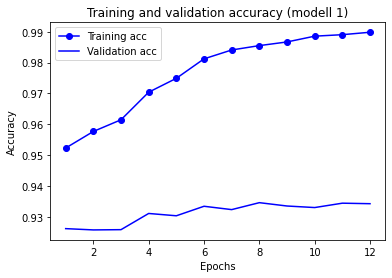

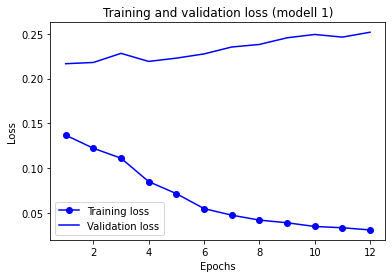

In [102]:
plot_history(history,epochs-noepochauto)

In [103]:
# Evaluate the model.
test_loss, test_acc = model.evaluate(test_images,to_categorical(test_labels))
print('Test accuracy: %.3f' % test_acc)
val_acc = eval(model,"val")
model.save("output/FashionMNIST/best_model.h5")

313/313 [==============================] - 1s 3ms/step - loss: 0.2667 - categorical_accuracy: 0.9302
Test accuracy: 0.930
375/375 [==============================] - 1s 3ms/step - loss: 0.2381 - categorical_accuracy: 0.9346
val accuracy: 0.9346


In [ ]:
# See what we got and how many parameters are used
model.summary()

# Analys
Gör en komplett analys av de optimerade modellerna du fått fram mha Keras Tuner. Några frågor man kan ställa sig:
* Hur jämför sig dessa värden, mha en Bayesiansk sökning, från de värden då fått fram i del 1 och del 2? 
* Vilka prestanda fick du för de olika fallen? 
* Finns det parametrar som ligger vid ändvärdena av den använda sökrymden? (i så fall kanske du borde köra om med utökade gränser?)
* Vilka hyperparametrar verkade vara mest betydelsefulla? 
* Kan man se någon trend bland parametrarna (tex antalet faltningskärnor i tidiga respektive sena lager, etc)? 
* Varför utför man samma experiment flera gångar "EXECUTION_PER_TRIAL = 2", dvs varför blir det inte samma resultat varje gång?
* Annat som du iaktagit?

## Svar:
**Jämförelse** De funna hyperparametrarna fokuserar mer på att ha en bred modell med fler noder än ett djup. Detta ser vi på att vi kan se detta på att det initiala filtret är 96 kannaler jämfört med 16 som jag använde under första modellerna. Modellen byggdes så att det initiala filtret dubblerades vid varje tillfälle som spatiella dimensionerna reducerades. `depths` kontrollerar djupet för varje block, d.v.s. hur många potentialla skip-connections det är per block (för illustration, see plotter av DiGraph ovan), denna parameter preseterar som bäst i den minska konfigurationen (en potentiell skip per block). Den gjorde det för de top fem olika modellerna. Vi kan också se att regulariserande parametrar som
* Batch-norm 
* Weight decay
är mindre i den nya modellen jämfört med den då jag ansatte värdena. Jag tror att detta beror på att jag försökte hålla ner skillnaden mellan träning och validationnoggrannheten. Optimeringsprocessen tar inte i hänsyn till att noggrannheten mellan träningdata och validation/test datat är hög utan försöker endast maximera validationnoggrannheten. Vi kan se det på att den färdigtränade modellen hade följande noggrannhet:

### Bayesiansk optimering
Prestanda för den bästa modellen som hittades med hjälp av bayesiansk optimering.
| Data | Noggrannhet (%) |
|---|---|
|Test| 93.00|

Modellens konfiguration:
| Hyperparametrar | Valda värden |
| --- | --- |
| filters | [96, 192, 384, 764] |
| inital_kernel_size | 5 |
| kernel_size | 3 |
| dropout | 0.15 |
| batch_norm | False |
| optimizer | Adam |
| learning_rate | 0.001 |
| weight_decay | 0.0 |
| clip_norm | 10 |
| activation | ReLU |
| depths | [1, 1, 1, 1] |
| pool | True |
| dense_units| [64,32] |
| skip | True |

### Itererad prestanda
Prestanda för den bästa modellen som hittades med hjälp av trial and error.
| Data | Noggrannhet (%) |
|---|---|
|Test| 91.49|

Modellens konfiguration:
| Hyperparametrar | Valda värden |
| --- | --- |
| filters | [16, 32, 64, 128] |
| inital_kernel_size | 5 |
| kernel_size | 3 |
| dropout | 0.15 |
| batch_norm | True |
| optimizer | Adam |
| learning_rate | 0.01 |
| weight_decay | 0.0 |
| clip_norm | 2 |
| activation | SeLU |
| depths | [1, 1, 1, 2] |
| pool | True |
| dense_units| [128,64] |
| skip | True |

Vi kan se att modellen som hittades med hjälp av bayesiansk optimering har en bättre testnoggrannhet än den som hittades med hjälp av trial and error.
## Top 5 modeller med bayesiansk optimering
Tabellen ovan under rubriken "Resultatet av de 5 bästa modellerna (baserat på valideringsnoggrannheten)" visar de 5 bästa modellerna som hittats via hyperparameter optimiering. Dessa modeller har många gemensamma parametrar vilket visar på att de troligen har en god effekt på modellens prestandard. Vi ser exempelvis att alla modeller använde sig av:
- Adam som optimeringsalgoritm
- Ingen batch-normalisering
- MLP med konfigurationen [64,32]
- Inlärningshastigheten 0.001
- Endast ett lager per block
Det är inte stora variationer varken i parameter uppstättning eller i testnoggrannhet men det är ändå intressant att de vilka parametrar som bidrar till goda resultat. Dessa parametrar anses vara de mest betydelsefulla eftersom de är gemensamma för alla modeller.

## Parametrar vid ändvärden
Inga parametrar drar åt något specifikt håll vilket är bra och visar att sökprocessen kunde utföras utan att några parametrar hamnade vid ändvärdena av den använda sökrymden. Det skulle eventuellt vara av intresse att prova en mindre konfiguration av MLP lager (dense_units) då alla modeller hade konfigurationen [64,32] vilket var den minsta möjliga konfigurationen.
## Exekvering per försök
Vi kör varje försök flera gånger för att testa så att initialiseringen av modellen har så liten påverkan som möjligt. Om en modell initialiseras dåligt kan det vara så att den inte alls konvergerar oavsett bra konfiguration det teoretiskt sett skulle ha varit. För att motverka detta kör vi varje modell fler än en gång.

# Uppgifter för väl godkänt

Utökning av Del2: Utforska de testfall som missklassificerades för en av dina toppmodeller, vilka typer av plagg verkar vara de som oftast blir fel på, om du tittar på dessa fel förstår du varför nätet har problem med dem?

In [90]:
# Din kod som utforskar de testfall som missklassificerade
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report
best_model = load_model("output/FashionMNIST/best_model.h5")
pred_scores = best_model.predict(test_images)
preds = np.argmax(pred_scores,axis=-1)
pred_scores = np.max(pred_scores,axis=-1)
class_report = classification_report(test_labels,preds,output_dict=True,target_names=class_names)


313/313 [==============================] - 1s 3ms/step


In [91]:
# Print report as table
!pip install tabulate
from tabulate import tabulate
headers = ["Class","Precision","Recall","F1-score","Support"]
table = []
for key in class_names:
    table.append([key,class_report[key]["precision"],class_report[key]["recall"],class_report[key]["f1-score"]])
    
table.sort(key=lambda x: x[3],reverse=True)
print(tabulate(table,headers=headers,tablefmt="github"))


| Class       |   Precision |   Recall |   F1-score |
|-------------|-------------|----------|------------|
| Trouser     |    0.993952 |    0.986 |   0.98996  |
| Sandal      |    0.986987 |    0.986 |   0.986493 |
| Bag         |    0.984064 |    0.988 |   0.986028 |
| Ankle boot  |    0.982794 |    0.971 |   0.976861 |
| Sneaker     |    0.964637 |    0.982 |   0.973241 |
| Dress       |    0.933801 |    0.931 |   0.932399 |
| Pullover    |    0.890185 |    0.916 |   0.902908 |
| Coat        |    0.889872 |    0.905 |   0.897372 |
| T-shirt/top |    0.879469 |    0.861 |   0.870136 |
| Shirt       |    0.794268 |    0.776 |   0.785028 |


## Performace across different classes
| Class       |   Precision |   Recall |   F1-score |
|-------------|-------------|----------|------------|
| Trouser     |    0.993952 |    0.986 |   0.98996  |
| Sandal      |    0.986987 |    0.986 |   0.986493 |
| Bag         |    0.984064 |    0.988 |   0.986028 |
| Ankle boot  |    0.982794 |    0.971 |   0.976861 |
| Sneaker     |    0.964637 |    0.982 |   0.973241 |
| Dress       |    0.933801 |    0.931 |   0.932399 |
| Pullover    |    0.890185 |    0.916 |   0.902908 |
| Coat        |    0.889872 |    0.905 |   0.897372 |
| T-shirt/top |    0.879469 |    0.861 |   0.870136 |
| Shirt       |    0.794268 |    0.776 |   0.785028 |

Vi kan se från tabellen ovan att modellen enkelt skiljer sig distinkt från klass till klass. Den kan bäst urskilja byxor, sandaler och väskor om man baserar prestandarden på klassens **F1-score**. Detta kan man eventuellt gissa eftersom de alla tre har relativt unika utseenden.
* Byxor har en tydlig form och är inte lika många som andra plagg.
* Sandaler har en tydlig skoform samt att den ofta är ihålig, vilket hjälper till att skilja den från andra skor.
* Väskor har likt byxorna en tydlig form som inte är lika många som andra plagg.
Notera att **F1-score** är en kombination av precision och recall och är en bra mått på hur bra en modell är på att urskilja en klass. Det beräknas med följande formel:

$$F1 = 2 \cdot \frac{precision \cdot recall}{precision + recall}$$



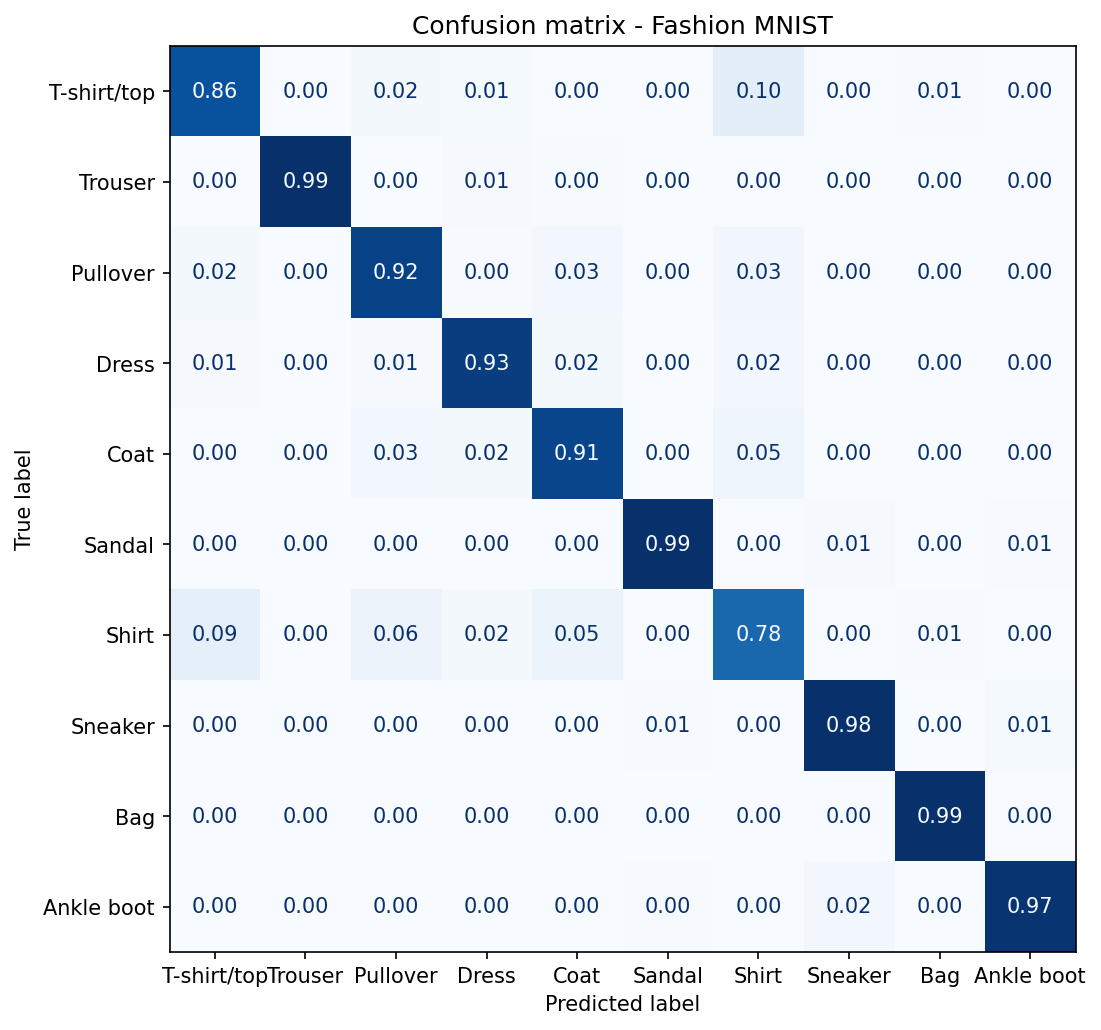

In [92]:
cm = confusion_matrix(test_labels,preds, normalize='true')
fig,ax = plt.subplots(figsize=(8,8),dpi=150)
ax.set_title("Confusion matrix - Fashion MNIST")
cm_display = ConfusionMatrixDisplay(cm, display_labels=class_names)
cm_display.plot(ax=ax,values_format='.2f',cmap='Blues',colorbar=False)


Vi kan se att modellen lätt missklassificerar tröjor/toppar och skjortor. Detta beror troligtvis på att dessa plagg är väldigt lika i stil och att de har likheter i formen.

### Missclassified test samples

Images shape: (10000, 28, 28, 1), labels shape: (10000,)


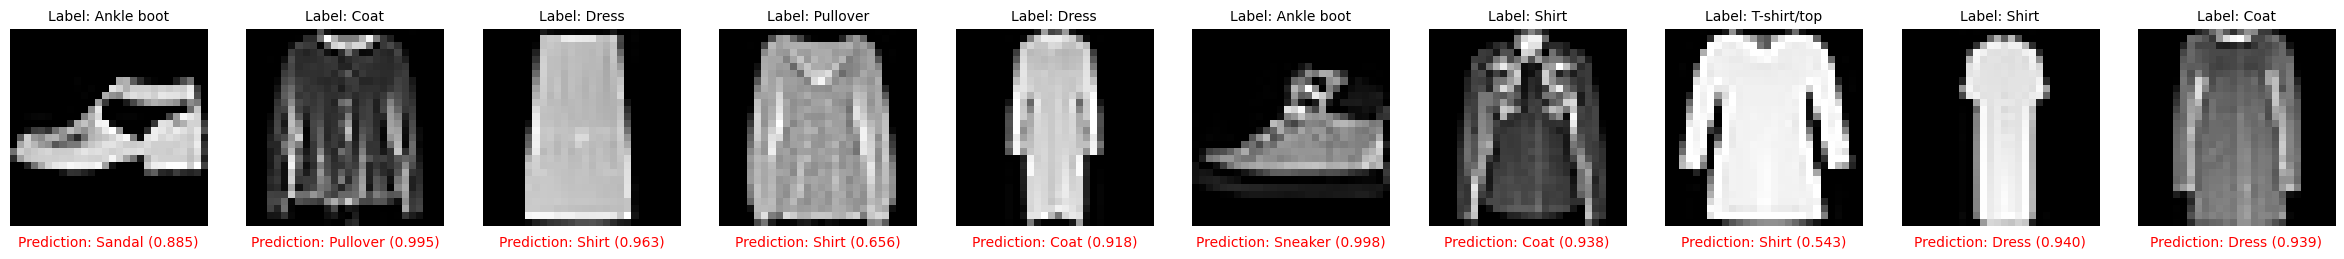

In [99]:
shirt_index = class_names.index("Shirt")
top_index = class_names.index("T-shirt/top")
# samples_idxs = np.where(((test_labels == shirt_index) | (test_labels == top_index)) & (test_labels != preds))[0]
samples_idxs = np.where((test_labels != preds))[0]
plot_sample(samples_idxs, data="test", n=10, preds=preds, pred_scores=pred_scores)

Man kan se att de element som missklassificeras är väldigt lika de som de tros vara av modellen. Man ser till exempel att olika typer av skor mixas ihop, att rockar och klänningar mixas och att tröjor och skjortor mixas. Om vi tagit hänsyn till färger hade troligen modellen preseterat bättre då den typiska färgen för en klänning ofta skiljer sig från den av en rock. Man hade dessutom 

Utökning av Del3: Implementera en undersökning där du även varierar antal lager i din modell, du kan ändra både faltningslager och kompakta lager (eng. dense layers) för att se ifall en ännu bättre modell kan hittas.

Tips: Det är nog bäst att använda en inkrementell/funktionell definition av modellen (där lager läggs till med "model.add(...)" för då blir det lättare att göra en for-slinga runt koden som lägger till ett visst antal lager. Jmf https://keras.io/guides/sequential_model/ 


```
    filter1=hp.Int('conv_pre_filter', min_value=32, max_value=160, step=32, default=64)
    kernel1=hp.Choice('conv_pre_kernel', values = [3,5], default=3)
    model = Sequential()
    # Add a first convolution layer (with input size)
    model.add(Conv2D(filters=filter1, kernel_size=kernel1, padding='same', activation='relu', input_shape=train_images[0].shape))
    # More fixed layers?
    model.add(....more layer definitions....) 
    # Add a varying number of layers
    no_layers = hp.Int('num_layers', 0, 3)
    for i in range(no_layers):
          model.add(Conv2D(filters=hp.Int(f'conv_{i+1}_units', ...parameters...), 
                          kernel_size=hp.Choice(f'conv_{i+1}_kernel', ...parameters....),
                          activation='relu'
                          )
                    )

```



## Svar:
Jag gjorde detta redan under uppgift 2c. Jag visste ej att det var en utökning så jag provar ännu fler arkiteturer för att se om jag kan hitta en bättre modell. Framför allt provar jag grundare modeller med inte så många downsamples.

In [115]:
# Din kod för en keras tuner modell som har antalet lager som en hyperparameter 
# och där du söker efter optimerade hyperparametrar för denna modell.
depth_combs = [[1,1],[1,1,1],[1,1,1,1],[1,2,3,4],[1,4,6,8]]
dense_combs = [[128,64],[64,32],[32,16],[16,10],[32]]
EXECUTION_PER_TRIAL = 2
MAX_TRIALS = 40
def build_model_MyModelArchitecture(hp):  
    # My build functions is already compatible with with to use a tuner via a dictionary.
    hp_f1 = hp.Int('conv_1_filter', min_value=32, max_value=128, step=32)
    hp_f2 = 2*hp_f1
    hp_f3 = 4*hp_f1
    hp_f4 = 8*hp_f1
    hp_filters = [hp_f1,hp_f2,hp_f3,hp_f4]
    hp_initial_kernel_size = hp.Choice('initial_kernel_size',[3,5,7])
    hp_kernel_size = 3
    hp_dropout = hp.Choice('dropout',[0.05,0.1,0.15])
    hp_batch_norm = hp.Choice('batch_norm',[False,True])
    hp_optimizer = hp.Choice('optimizer',['adam','sgd'])
    hp_learning_rate = hp.Choice('learning_rate',[1e-2,1e-3,1e-4])
    hp_weight_decay = hp.Choice('weight_decay',[1e-2,1e-3,1e-4])
    hp_clip_norm = hp.Choice('clip_norm',[1.0,2.0,10.0])
    hp_activation = hp.Choice('activation',['relu','selu'])
    
    i = hp.Int('depths',min_value=0,max_value=len(depth_combs)-1,step=1)
    hp_depths = depth_combs[hp.Choice('depths',[i for i in range(len(depth_combs))])]
    # hp_pool = hp.Choice('pool',[True,False])
    hp_pool = True
    hp_dense_units = dense_combs[hp.Choice('dense_units',[i for i in range(len(dense_combs))])]
    hp_skip = hp.Choice('skip',[False,True])
    hyperparams = {
        "filters":hp_filters,
        "initial_kernel_size":hp_initial_kernel_size,
        "kernel_size":hp_kernel_size,
        "dropout":hp_dropout,
        "batch_norm":hp_batch_norm,
        "optimizer":hp_optimizer,
        "learning_rate":hp_learning_rate,
        "weight_decay":hp_weight_decay,
        "clip_norm":hp_clip_norm,
        "activation":hp_activation,
        "depths":hp_depths,
        "pool":hp_pool,
        "dense_units":hp_dense_units,
        "skip":hp_skip,
    }
    model = new_model(hyperparams)
    return model
# Bayesian search which also searches for batch_size
tuner = MyTuner(
    build_model_MyModel, ##### Laboration: Change this to 'build_model_MyModel' #####
    max_trials=MAX_TRIALS,
    objective='val_categorical_accuracy',
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='output-architecture',
    overwrite=True,
    num_initial_points=10, # Start with 10 random points and then do more structured search
    project_name='FashionMNIST'
)
noepochauto = 12   ## Max number of epochs per trail (but we have early stopping so this max is probably not reached)
es = tf.keras.callbacks.EarlyStopping('val_loss', patience=2, restore_best_weights = True)
tuner.search(train_images, to_categorical(train_labels), 
             epochs=noepochauto,
             validation_data=(val_images, to_categorical(val_labels)), 
             callbacks=[es])

Trial 40 Complete [00h 01m 18s]
val_categorical_accuracy: 0.2108749970793724

Best val_categorical_accuracy So Far: 0.9246666729450226
Total elapsed time: 01h 05m 14s
INFO:tensorflow:Oracle triggered exit


Epoch 19/30


2023-04-12 07:16:28.382988: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/drop_0_0/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


94/94 [==============================] - 26s 266ms/step - loss: 0.1269 - categorical_accuracy: 0.9542 - val_loss: 0.2197 - val_categorical_accuracy: 0.9254 - lr: 0.0010
Epoch 20/30
94/94 [==============================] - 24s 260ms/step - loss: 0.1044 - categorical_accuracy: 0.9620 - val_loss: 0.2373 - val_categorical_accuracy: 0.9243 - lr: 0.0010
Epoch 21/30
94/94 [==============================] - ETA: 0s - loss: 0.0932 - categorical_accuracy: 0.9657
Epoch 21: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
94/94 [==============================] - 24s 261ms/step - loss: 0.0932 - categorical_accuracy: 0.9657 - val_loss: 0.2343 - val_categorical_accuracy: 0.9283 - lr: 0.0010
Epoch 22/30
94/94 [==============================] - 24s 259ms/step - loss: 0.0590 - categorical_accuracy: 0.9783 - val_loss: 0.2614 - val_categorical_accuracy: 0.9303 - lr: 5.0000e-04
Epoch 23/30
94/94 [==============================] - ETA: 0s - loss: 0.0444 - categorical_accuracy: 0.9838
Epoch

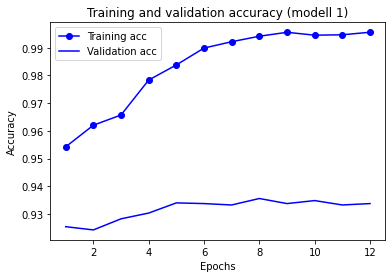

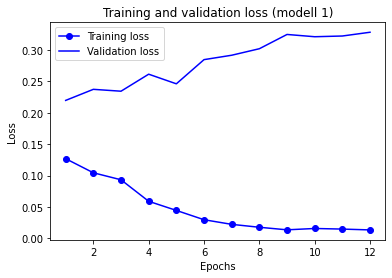

313/313 [==============================] - 4s 12ms/step - loss: 0.3239 - categorical_accuracy: 0.9357
test accuracy: 0.9357
375/375 [==============================] - 4s 12ms/step - loss: 0.3020 - categorical_accuracy: 0.9356
val accuracy: 0.9356
1500/1500 [==============================] - 18s 12ms/step - loss: 0.0096 - categorical_accuracy: 0.9976
train accuracy: 0.9976


In [117]:
# Fine-tune the model using the best parameters found as we might not be fully trained
model = tuner.get_best_models(num_models=1)[0]

epochs = 60      ## (max) number of epoch to run
opt_batch_size = tuner.get_best_hyperparameters()[0]['batch_size']

# Set callback functions to early stop training
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', mode='auto', verbose=1, patience=4, restore_best_weights = True), ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.0001, verbose=1)
] # NOTE: Adding learning rate scheduler.
# Continue to train the model. (note that we are continuing from the training done during tuning)

history = model.fit(
  train_images, to_categorical(train_labels),
  epochs=epochs,
  batch_size=opt_batch_size,
  verbose = 1,
  validation_data=(val_images, to_categorical(val_labels)),
  initial_epoch=epochs-noepochauto, ## how to get this number???? from... "(root).optimizer.iter" maybe
  callbacks=callbacks
)

plot_history(history,epochs-noepochauto)

test_acc = eval(model,"test")
val_acc = eval(model, "val")
train_acc = eval(model, "train")
model.save("output-architecture/FashionMNIST/best_model.h5")



## 5 Bästa modellerna

In [119]:
# Let us dump the n-best

if True:
  explorenbest = 5

  # Suppress warnings about optimizer state not being restored by tf.keras.
  tf.get_logger().setLevel('ERROR')

  # Print a heading
  vals = tuner.get_best_hyperparameters(num_trials=explorenbest)[0].values
  print('Test accuracy ', end = '')
  for keys,values in vals.items():
      print('%15s ' %(keys), end = '')
  print('\n')

  # Now print each trail on a seperate row from best to worst
  for ix in range(0,explorenbest): 
    # evaluate this trail
    model = tuner.get_best_models(num_models=explorenbest)[ix]
    test_loss, test_acc = model.evaluate(test_images,to_categorical(test_labels), verbose=0)
    print('%15.3f ' % test_acc , end = '')
    # get this trail's hyperparameters
    vals = tuner.get_best_hyperparameters(num_trials=explorenbest)[ix].values
    for keys,values in vals.items():
      if isinstance(values,(int,float)):
        print('%15.4g ' %(values), end = '')
      else:
        print(f"{values:>15}",end="")
    # end this line and start the trail
    print()

Test accuracy   conv_1_filter initial_kernel_size         dropout      batch_norm       optimizer   learning_rate    weight_decay       clip_norm      activation          depths     dense_units            skip      batch_size 

          0.926             128               5             0.1               0            adam          0.001           0.001               1            relu              3               0               1             512 
          0.921             128               3            0.05               0            adam          0.001          0.0001               1            relu              0               1               0             512 
          0.914             128               3            0.05               0            adam          0.001          0.0001               2            selu              1               1               0             512 
          0.912             128               3            0.15               0            adam        

In [118]:
vals = tuner.get_best_hyperparameters(num_trials=5)[4].values
for keys,values in vals.items():
    print(f"{keys}:{values}")
    
model.summary()

conv_1_filter:32
initial_kernel_size:3
dropout:0.15
batch_norm:0
optimizer:adam
learning_rate:0.001
weight_decay:0.001
clip_norm:1.0
activation:relu
depths:0
dense_units:2
skip:0
batch_size:512
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 Initial_Conv (Conv2D)          (None, 28, 28, 128)  2048        ['input_1[0][0]']                
                                                                                                  
 conv_0_0 (Conv2D)              (None, 28, 28, 128)  147584      ['Initial_Conv[0][0]']           
                                                                                                  

Vi ser att modellen preseterar i paritet med den som hittades i uppgift 3. Den nya modellen är betydligt grundare men använder samtidigt fler parametrar. Detta är pågrund utav att den endast använder två st downsamples innan output blocket med en MLP vilket resulterar i ett betyldigt större output lager och 40,799,178 parametrar jämfört med den tidigare modellen som endast hade ca 4 miljoner parametrar.

### Bayesiansk optimering
Prestanda för den bästa modellen som hittades med hjälp av bayesiansk optimering.
| Data | Noggrannhet (%) |
|---|---|
|Test| 93.57|

| Hyperparametrar | Funna värden |
| --- | --- |
| filters | [32, 64] |
| inital_kernel_size | 3 |
| kernel_size | 3 |
| dropout | 0.15 |
| batch_norm | False |
| optimizer | Adam |
| learning_rate | 0.001 |
| weight_decay | 0.001 |
| clip_norm | 1 |
| activation | ReLU |
| depths | [1, 1] |
| pool | True |
| dense_units| [32,16] |
| skip | False |

Vi ser att modellens arkitektur är helt annorlunda än den tidigare funna och att de regulariserande parametrarna är betydligt högre. Detta är troligtvis för att modellen innehåller 10x fler parametrar och därför måste den regularisera modellen betydligt striktare för att inte överträna modellen.
